# Learning to estimate world state

## Introduction


Planning is undoubtedly a relevant tactic in AI and Robotics. Many tasks, such as efficient navigation or chess-playing, rely on agent's ability to simulate possible futures to determine most favourable actions. However, in order to predict reliably, agents require robust models of their environments. While the engineer often has the relevant knowledge, it may be difficult to transfer it to the agent.
1. It may be difficult to express one's understanding algorithmically -- e.g. how does one assess goodness of a Go move?
2. The mismatch between abstract mathematical models and complex unstructured reality often means the predicitions are far from useful. 

When knowledge transfer problem is challenging, one may attempt to create an agent that gains the relevant understanding from its own experience. This work focuses on construction of deployable predictive models from scratch. The goal is to understand, which aspects of environments make the learning more difficult and what subproblems need to be solved.

The idea of agents building their own models is definitely not novel: an early example is [Dyna](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume4/kaelbling96a-html/node29.html). However, recent advances in deep learning enabled automated understanding of truly complex relationships and formation of rich representations. 

Impressive recent examples where agents learnt to successfully predict environments include:
1. [Recurrent Environment Simulators](https://arxiv.org/abs/1704.02254) and [Action-Conditional Video Prediction using Deep Networks in Atari Games](https://arxiv.org/abs/1507.08750), where a deep recurrent network learns to predict future screen frames based on past percepts and joystick data. See videoes [here](https://drive.google.com/drive/folders/0B_L2b7VHvBW2SEllTmlEX1l0RGc).
2. [Prediction Under Uncertainty with Error-Encoding Networks](https://arxiv.org/abs/1711.04994), where a network learns to sample possible futures by generating likely future percepts - in effect learning a stochastic model of the environment.

Still, even those cutting edge algorithms struggle in more challenging environments. The first one is not very good at modelling stochastic state transitions. The second one was not shown to be able to produce long-term predictions.

In this work, we attempt to delineate different challenges in learning environment model from percepts. To achieve this, a configurable simulator of billiard balls was implemented. Then, a deep neural architectured was trained to predict to predict the outputs of the simulator. Since the underlying model was available, the results of predictions can be compared to near-optimal performance of sequential monte carlo methods (also know as particle filter state estimation). By considering information available to the network and loss functions which shape its learning, one can make educated guess about performance of the architecture in different learning scenarios.

This document is structured as follows:

**Section 2** describes the problem agents learning about the world are facing through an information/computation 
flow perspective. It then describes variations in the problem.

**Section 3** 


## Problem statement



### General problem

Learning agents are spawned in various environments and are given different tasks to complete. Let us start by considering an abstraction of time-aware agent learning about its environment (Figure xxx). The arrows in the graph represent computations -- however, they can also be viewed as flow of information. The vertical arrows coincide with the direction of flow of time (downwards).

Left hand side of the diagram represents computations "carried out" by the environment. State of the world evolves according to some rules.

The right hand side refers to computations in agent's mind. The agent can try to learn the state of the world thanks to information flowing through the observation channel. How much of the world's state can agent directly observe depends on the problem.

How information is processed in the right hand side of the graph depends on the learning algorithm chosen for the task.

<img src="images/general_problem.png" width="500" align="center">
<i>Figure xxx: Graph representing computations and flow of information in the world and through agent's mind.

Consider the variables from the diagram:
* $s_t$ is state of the environment at time $t$
* $T_W$ is a computation that takes the environment from state $s_t$ to $s_{t+1}$. That is, $T_W : s_t \mapsto s_{t+1}$ 
* $o_t$ is observation at time $t$ produced by a particular sensor based on the underlying world state $s_t$
* $P_S$ is a computation that generates an observation $o_t$ from state $s_t$. That is, $P_S : s_t \mapsto o_t$
* $bs_t$ is a representation of agent's knowledge at time $t$
* $T_B$ is a computation that propagates agent's beliefs forward in time
* $P^{-1}_{B}$ is a computation that enables update of agent's belief using the observation
* $a_t$ part of the world state that is under direct control of the agent, the agent may influence the trajectory of future world states by controlling this variable (does not apply to passive agents).

The left hand side of the graph can be viewed as a [Markov process](https://en.wikipedia.org/wiki/Markov_chain) which is partially observable through the sensory channel. However, usually modelling a phenomenom as Markov process implies deciding what the format of the state is, what does transition and observation functions are. For a generalised problem we are agnostic about those. In some tasks one might decide to implement the agent with a specific format of those in mind, in others it might be the task for the agent to deicide what is the right choice of representation for the environment state and learn how transitions occur.

Representing the problem of an agent learning about its environment in as such computational graph will enable us to clearly observe different challenges that arise during learning. We will see how $T_W$ and $P_S$ vary between environments such as Atari games and colliding billiard balls and learn what it implies about difficulty of learning about those environments. Lastly, this view translates well into design of modular neural networks.

### Different tasks for agents

Let us consider a couple of possible tasks for agents along with examples of environments usually associated with those problems. The choice of the problem dictates what kinds of computations will be implementing the agent.

#### State estimation

In applications such as target tracking or robot navigation it is useful to estimate the state of the world using imperfect sensors. For example, one might be interest in tracking positions of ships scattered accross large area using noisy data from radars.

The particular variable of interest might be $(x, y)$ position of a particualar vessel and the observations consitute distance and angle towards the target (both noise corrupted).

In such problem it is usual to embed the agent with knowledge about the underlying Markov process. This informs the agent about how the state (ship's position) tends to evolve over time, and how to update one's belief about target position using data from the sensor. The state is clearly defined and the agent is not required to come up with a suitable representation for the problem.

Well-known examples of algorithms for this class of problems include [Kalman filter (KF)](https://en.wikipedia.org/wiki/Kalman_filter) (KL) and [Particle filter (PF)](https://en.wikipedia.org/wiki/Particle_filter) (also known as Sequential Monte Carlo). 

For these algorithms, the representation of agent's knowledge ($bs$) as well as methods for propagation beliefs into future ($T_B$) and probablistic update based on measurements ($P^{-1}_B$) are all fixed and  defined explictly by the programmer.

In Kalman filter the knowledge is represented by multivariate Gaussian distribution over the variables of interest, eg for a target in 2D space those might be position and velocity:

<center>$s = (x, y, \dot{x}, \dot{y})^T$</center>

In a particle filter, the distribution over states is represented by a collection of copies of the state vector. Because of this PF can represent and model non-linear processes which comes at increased computational cost relative to KF.

Core weakness of this family of methods is the fact that the model of the world ($T_W$) and the sensor ($P_S$) must be at least approximately known. Any mismatch will result in lower performace of the estimators.

In this problem most of the agent's mind is fixed (ie not changing with time).

(Pure state estimators are passive observers and do not perform actions $a$. However, in a closely related field of active sensing, agents can control their sensors (eg rotate a camera) to allow for more efficient estimation of state.)

#### Reinforcement learning

In reinforcement learning the agent interacts with the environment by selecting actions ($a_t$) and tracks state of the environment ($s_t$) through observations (see game video below) ($o_t$). The agent is also provided with a scalar reward signal (r_t), which can be viewed as another kind of observation. The goal is to learn how to act in a given situation, so that the rewards observed are maximised.

Atari console is a recently popular testbed for a host of deep learning algorithms. The most common goal for this environment is learning to play (ie select joystick commands) in a way that maximises the game score. The problem has been popularised by seminal reinforcement learning paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). State of the art deep learning algorithms perform at superhuman level after roughly a day of exposure to the environment.

The environment is popular because because it lies at the intersection of being sufficiently:
* difficult to be interesting for humans to play
* simple for early deep reinforcement learning to be successful
* accessible so that large amounts of data can be gathered for training 

<img src="images/atari.gif" width="500" align="center">
<i>Figure xxx: A series of observations from Space Invaders on Atari 2600.</i>

Let us map Atari game world on abstraction developed earlier:
* $s_t$ is memory state of the console engine at time $t$. It is not human-readable, but can be understood by reading game's code.
* $T_W$ is the code that performs operations on the memory and reads the joystick. The transition function is completely deterministic given the random seed. Without it, the transitions are mildly stochastic for most games (eg which alien fires a projectile at a given time), but can be significant for some (in Asteroid the player can be teleported to a random location).
* $P_S$ there are two sensory modalities: 
    * game state is projected on the screen
        * this is fully deterministic (ie given state always leads to the same image)
        * the state is almost fully-observable -- still, there is usually some information that cannot be inferred from a single screen, eg random seed, direction of movement of enemies 
    * reward is extracted from the game state -- fully deterministic -- this signal is used as a reward in reinforcement learning 

<img src="images/dqn.png" width="800" align="center">
<i>Figure xxx: A deep convolutional neural network learns a mapping from observations ($o_t$) to actions ($a_t$) that leads to highly rewarded behaviour. The layers between input and output can be viewed as agent's representation of knowledge ($bs_t$) about the aspects of game state ($s_t$) relevant for the problem.</i>

In [1]:
#Interestingly, most Atari playing agents (like [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) do not implement $T_B$ computation -- the time link is left out. Instead multiple consecutive frames are concatenated and then interpreted by convolutional neural network which implements $P^{-1}_B$). This is possible because $s$ is almost fully-observable via $o$. Multiple frames tell the agent everything there is to know about the state of the game.


In this setting, the agent constructs knowledge representation on its own -- ie the state representation $bs_t$,  belief state transition $T_B $ and observation interpretation $P^{-1}_{B}$ are all learnt by the agent and suited to the problem (using optimisation methods for neural network training).

Under such incentives one can expect that parts of the console state that are not relevant for maxisiming game score will not be represented by the agent (which is reasonable and efficient). On the other hand, the aspects of the game that strongly affect the score (eg being hit by a bullet), will be appreciated by the agent.

Interestingly, in this setup one should not expect that the agent attempts to create a simulation of the environment in its mind. That is, the agent will not try to find internal state transition ($T_B$) such that it mimics console's state transition ($T_W$). Since every observation tells the agent almost everything there is to know about the current game state, there is little pressure to learn about state transitions. It is sufficient to remember which button presses lead to good consequences.

This is generally beneficial -- there is no point in learning something that does not help to improve on the performance metric. However, it could be argued that the agent is not using all of the data it is exposed to efficiently. Predictive learning, where the agent is tasked also with prediction of future percepts, is aiming to help with this problem.

#### Predictive learning

In the hopes of making reinforcement learning more data efficient and also enable agents to plan (by simulating results of actions), Yann LeCun has recently advocated that agents also learn predict future percept. This enables unsupervised learning (no labels required) to form richer representations of environments. The prediction problem corresponds to the modified graph below.

<img src="images/special_problem.png" width="700" align="center">
<i>Figure xxx: In this task the agent produces reconstructions of observations $\hat{o}_t$. Additionally, the access to observations may be restricted for many time steps, so that the agent is incentivised to learn to propagate information forward in time.</i>


The idea is that whatever representation is sufficient for prediction of the environment (the observations to be more specific), should be suitable for estimation of 'goodness' (RL value) of a state or action selection. This representation can be formed without gathering any additional data from the environment -- the process can be completed in parallel to standard reinforcement learning. Additionally, the learnt representation along with transition function can be used to simulate the environment and plan ahead.

Again, Atari testbed is being used also for examining predictive powers of neural networks. In this setting the agent is tasked with prediction of future percepts (up to hundreds of time steps ahead). Video examples of predictions can be found in the following directory: [here](https://drive.google.com/drive/folders/0B_L2b7VHvBW2SEllTmlEX1l0RGc).

<img src="images/env_sims.png" width="700" align="center">
<i>Figure xxx: Graphical representation of computations in neural architecture for Atari prediction in [Recurrent Environment Simulators](https://arxiv.org/abs/1704.02254). $x_t$ and $\hat{x}_t$ are game frame and its reconstruction at time $t$, $s$ corresponds to belief about game state, $a$ corresponds to joystick action.</i>

The only information supplied to the agent are observations and joystick actions (which can be viewed as an observation or part of state). In the process of prediction of future percepts, the agent:
1. updates its belief $bs_t$ about the state of environment $s_t$ using the observation $o_t$ (convolutional network)
2. propagates its belief forward in time to $bs_{t+1}$ (recurrent network)
3. maps the belief $bs_{t+1}$ onto observation space $\hat{o}_{t+1}$ (deconvolutional network)

The procedure is improved iteratively via gradient descent on the error in reconstruction. Once the network has converged it was capable of simulating behaviour of Atari console for hundreds of timesteps. Effectively, the agent has found a sufficiently rich state representation along with transition function that matches closely the original residing in the Atari 2600.

However, the success in Atari prediction problem did not readily translate to other domains. Video predictions continue to be very challenging.

A particular feature of Atari problem that makes it relatively easy is the fact the that games used in the aforementioned experiments where mostly deterministic. That is, $T_W$ contains little noise. This means, that the agent can do well on the task by representing the state of the game and simulating it forward. This is in contrast to having a belief over a distribution of possible states and propagating this distribution forward in time.

My current interest is in extending the method used in Atari prediction research for environments that contain significant levels of stochasticity. More on how this is being tackled in Section 3.

### (Extra) Philosophy of science

Humanity's quest for knowledge can also be viewed through the lens that we have established. Science aims to construct and retain best explanations about how the underlying world works. To achieve that we are a very flexible learner. We use various representation for the same object depending on the problem that is being solved. For example, a glass full of liquid can be modelled as:
* collection of molecules by a physicist
* a substance with particular chemical properties by a chemist
* a single, rigid object by someone who is consuming a morning coffee

Our flexibility in which model should be used can go as far as in quantum physics, where physicists offer multiple interpretations on how the reality behaves at the lowest levels and do not really worry about which is "true" as long as they all make the same predictions about the future.

In language established in this document this means -- it does not matter which state representation you choose as long your predictions match to the observations.

Still, in our search for answers we are driven by values. We are not abstractly trying to predict everything. We focus our attention on predictions of phenomena that are consequential to our survival and improvement of quality of life.

### Dimensions of the problem

Now that a number of examples of environments, agents and corresponding tasks were considered let us try to abstract away some components of the problem. Let us see what effect do those have on difficulty of training for an agent.

#### Observability

**Full** -- $P_S$ is an identity matrix -- the agent has full access to state at all times. Example: many abstract games, eg chess.  In such settings finding suitable transition function might be easier (since state is known at all times). Not a very interesting case since it's rarely found in the real world.

**High** -- multiple states can map to the same observation, because of that state cannot be directly inferred from a single observation. Still it is possible to end up with a narrow distribution. Multiple consecutive observations can possibly eliminate all relevant uncertainty. Examples: Atari games, robot localisation, military target tracking. Since the agent has a poorer estimate of world state at all times it is more challenging to infer the transition function.

**Low** -- even with large number of observations it is not possible to infer everything about the state of the world. Only some parts of the state can be known with high certainty. Examples: agents embedded in large worlds, eg games like GTAV or Starcraft, simultaneous localisation and mapping, living as a human. The transition function has to be learn by part by part since entire state is never known with high certainty.

#### Observation noise level

The noisier the observations, the more difficult it is to infer the state that lead to generation the observation. Higher level means that the agent has to maintain a broader distribution over possible states of the environment. All real-world measurements are noise-corrupted to some extent.

#### Process stochasticity

**Deterministic transition function** -- in such environments the agent that already possess a good approximation of $T_W$ can predict arbitrarily far into the future (provided computational resources are sufficient). If the agent can narrow down its beliefs about state to a single option, from that point onwards it can simply simulate the environment rather than propagating its beliefs about the environment.

**Stochastic transition function** -- any information that the agent gains about the environment is gradually lost as the state evolves in a random manner. The agent has to update its beliefs using observations.

#### Process complexity

It is possible for the underlying environment to be completely deterministic, yet composed of so many parts or complicated rules that to the agent it appears stochastic (either because of lacking model and shortage of computational resources).

It is likely that die throwing as a macroscopic phenomenom is practically governed by Newtonian mechanics and is almost completely deterministic (let us not go into details). Still, for any human onlooker, completely incapable of predicting the result from initial die position and force used, the throw will feel entirely random.

Systems that are determinisitic but chaotic (small change in initial conditions leads to large difference in outcome) often have to be modelled as stochastic anyway. Still, the level of chaos that pushes the system into as-if-it-was-stochastic region depends on the predictive power of the agent. Ie unpredictability can be a feature of the mind observing the process rather than of the process itself.

#### Agent's structure

For different problems different parts of the agent's mind can be made flexible. For example, in state estimation the problem representation and state transition are given and immutable. In problems where neural networks are used, the agent forms the representation based on the incentives provided by the loss function.

### (Extra) More things to discuss

#### Is predicting worth it?

It is certainly true, that for some problems it is not worth it to make diligient plans relying on predictions (model-based reinforcement learning). Sometimes it is better to just do it (model-free reinforcement learning). What distinguishes the settings where either of these tactics is preffered to the other one? This certainly calls for a longer discussion. Let us bring some points for now.

When do humans plan vs. just act?
* Degree choice -- plan
* Selecting friends -- just act
* Marry someone -- plan
* How to play football -- just act
* How to go through complicated crossroads -- plan
* What to eat -- just act (mostly)

How does that relate to Kahneman's System1 and System2?

Where does model-free RL vs. planning succeed?
* high-dimensional, no model available -- MFRL
* chess, Go, etc. -- mix, but more like planning
* robot locomotion -- planning
* robot manipulation -- mix
* simulated learning to walk -- MFRL

#### Belief propagation is more difficult than simulation

## Learning to represent and track world state

In the previous section we saw that Deepmind successfully implemented an algorithm capable of learning state transitions of Atari 2600 games. As a result the deep neural network can be used to simulate of the environment it was trained on. Unfortunately, Atari 2600 environment is a highly-observable and mostly deterministic. In other words, it is very different from our world. Thus the method cannot be readily ported to, for example, autonomous cars, which would probably benefit from the ability to predict future.

In this section, I outline some of tactics and problems associated with enabling high-dimensional percept predictions for stochastic environments. Note, that particular methods and experiment results are not presented here, but will be shown in a later paper.

### Simulated environment

In order to have full control over the difficulty of the learning task a contrallable simulator was implemented. This allows for changing of the dynamics of the environment. In the simulation billiard balls are interacting via Newtonian mechanics. The parameters of the simulation can be controlled in order to make the learning task more challenging. For example, the level of stochasticity in ball motion (random force perturbation) can be controlled.

The balls are simulated in a continuous space. Depending on the setting the balls can pass through each other or walls to emerge on the other side of the area. The state of simulation is projected onto $28$ by $28$ black and white image. This image serves as an observation to the agent. 

See samples generated by the simulator below.

In [10]:
%cd ~/code/projects/nn-play/
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from IPython.display import HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/home/ira/code/projects/nn-play


Inspect *balls_sim* for details of simulation.

In [3]:
from balls_sim import World, DEFAULT_SIM_CONFIG
gif_counter = 0

In [14]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['n_bodies'] = 3
conf['dynamics_noise'] = 0.01
conf['ball_action'] = 'bounce'
conf['wall_action'] = 'bounce'

w = World(**conf)
gif_counter += 1
ims = []
for i in range(150):
    w.run()
    ims.append(w.draw())

imageio.mimsave("ims/{}.gif".format(gif_counter), ims)
HTML('<img src="../ims/{}.gif" width="280">'.format(gif_counter))

### Baseline state estimator -- Particle filter (Sequential Monte Carlo)

Before training a neural network to predict sequences of balls interacting it is useful to construct a model-based baseline. In this case a particle filter (PF) is used. It is a standard method for state estimation when models of phenomenom and sensor are known. See Section 2.2.1 for some information on state estimation.

PF operates by running $n$ simulations of the environment in parallel (prediction step). The simulations that are unlikely to produce a measurement similar to the one observed are decimated (update step). The copies of the simulated environment consitute samples from the belief distribution of the filter.

PF operates only on structured data (ie not images). However, the belief distribution over structured $(x, y)$ positions can be converted into images. The higher the uncertainty associated with a position of a given ball, the more blur there is in the image.

See videos from a run of simulation (ground truth), PF's belief, a representative sample from the belief distribution.

The graph shows the error in reconstruction of the image given PF's beliefs. These functions are of interest because this error function will be used to train the neural network is gradient descent.

In [16]:
from particle_filter import ParticleFilter  # see here for implementational details

Baseline is 0.04543811455368996


Ground truth,Belief,Sample
,,


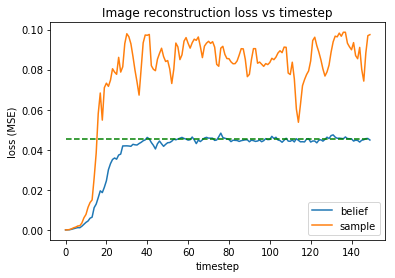

In [19]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
# conf['wall_action'] = 'bounce'
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
# conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 4
conf['ball_action'] = 'bounce'
conf['wall_action'] = 'bounce'

w = World(**conf)
gif_counter += 1

pf = ParticleFilter(conf, n_particles=400)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_belief = []
ims_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

for i in range(150):
#     if i < 8:
#         measures = [body.pos for body in w.bodies]
#         pf.update(measures)
#         pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[0].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_belief.append(belief)
    ims_sample.append(sample)


imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept)
imageio.mimsave("ims/{}-belief.gif".format(gif_counter), ims_belief)
imageio.mimsave("ims/{}-sample.gif".format(gif_counter), ims_sample)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Baseline is {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_sample_mse)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["belief", "sample"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Belief</th> 
    <th>Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-sample.gif" width="140"></td>
  </tr>

</table>""".format(gif_counter))

### Predictive Autoencoder